# CaliDHRI Day 2: Afternoon

## Outline
* Introduction to topic modeling
* Understand and import the data
* Prepare the data
* Structure the data
* Run the algorithm and see the topics
* BREAKOUT ACTIVITY
* Visualize the topics
* BREAKOUT ACTIVITY
* Daily wrap-up

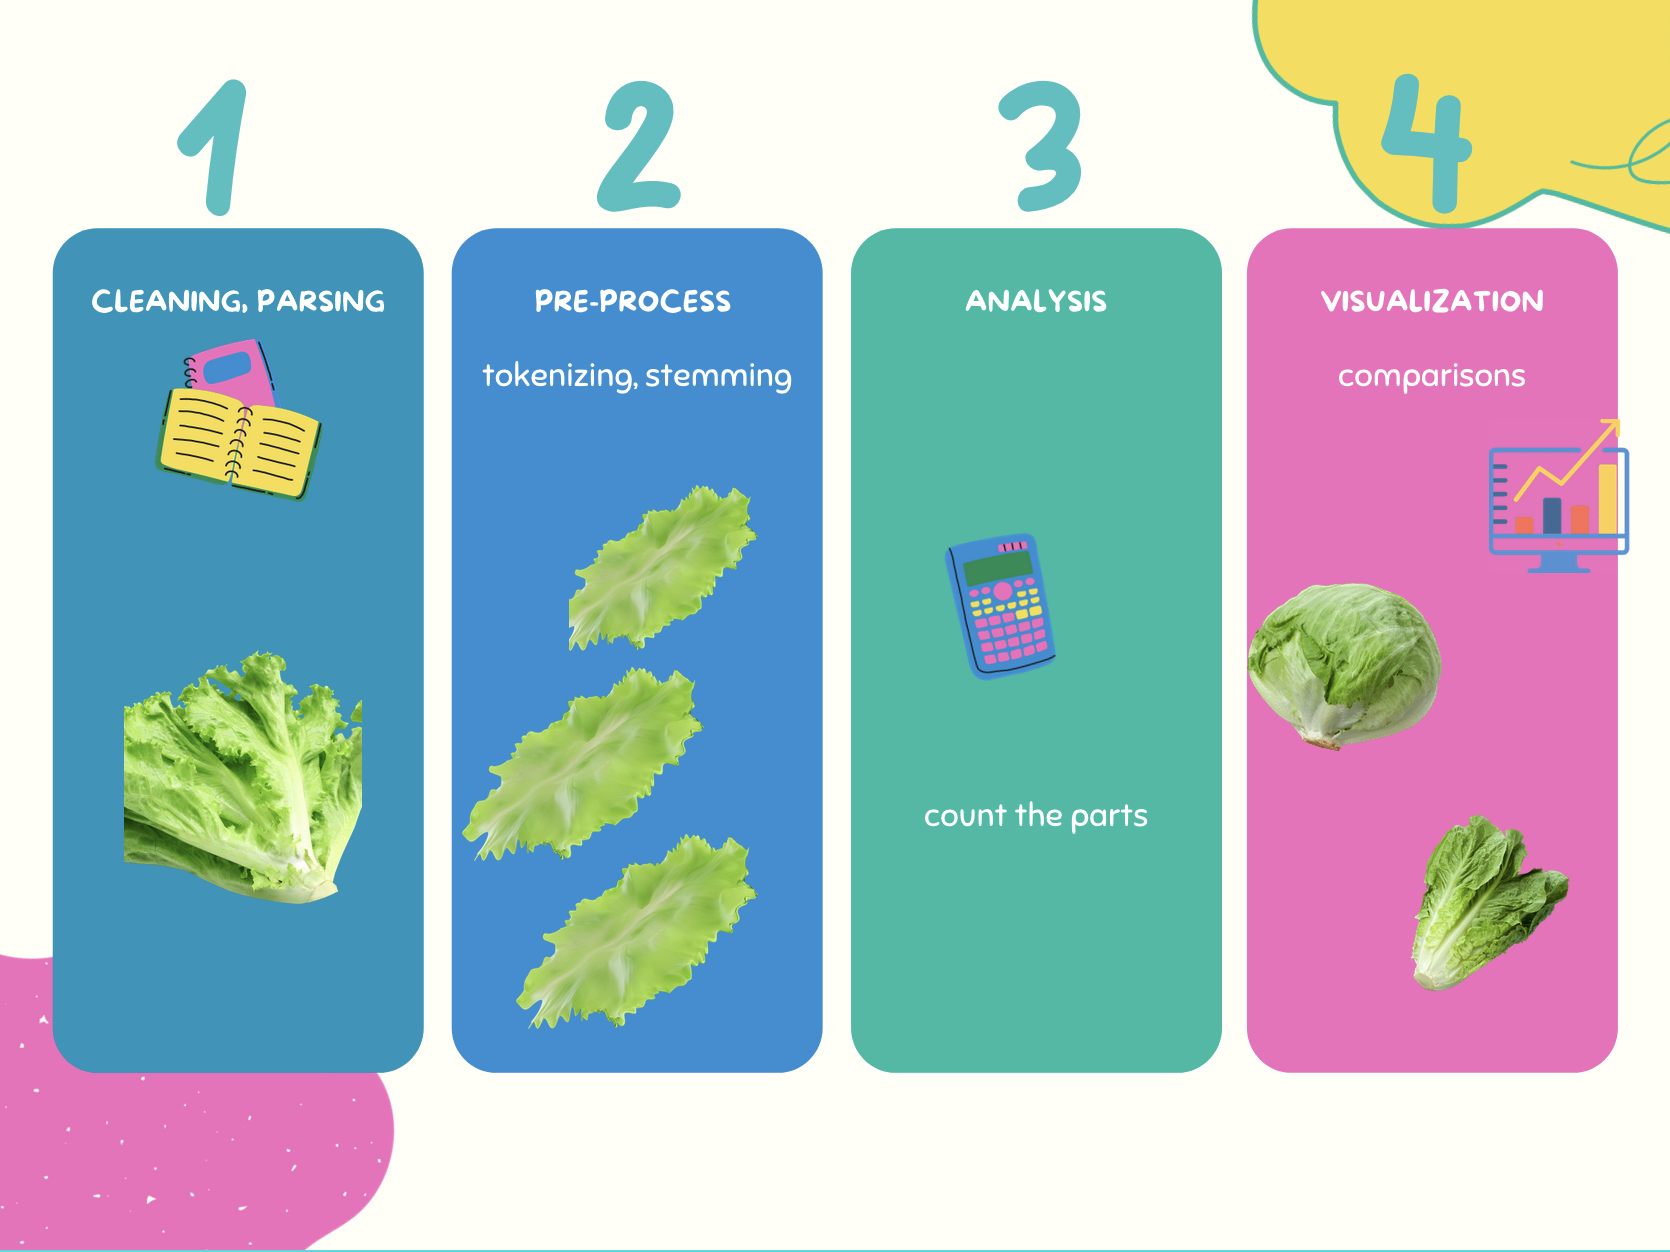

## Introduction to topic modeling

### What is topic modeling anyway?

* Popular approach to "distant reading" a corpus. 
* There are different approaches
    * We will be doing LDA topic modeling
* Unsupervised machine learning
* Algorithm learns from the data to make guesses about "topics" in the data
* The topics are lists of words

### Uses for topic modeling
Useful tool for understanding the subject matter of a dataset -- sometimes one that is too large for close reading or as a supplement to close reading.

Originally created for large corpora with relatively large documents (e.g., thousands of science publications). 


### Topics are probabilities of aboutness

* Basic logic: words that tend to co-occur in a corpus are likely about the same topic. 
* The corpus is divided into chunks called documents. 
* The algorithm checks each word in each document, and if they are likely to co-occur, it then groups them into topics. 
* It's up to the human to analyze the words in the topics and make an assessment of aboutness. 


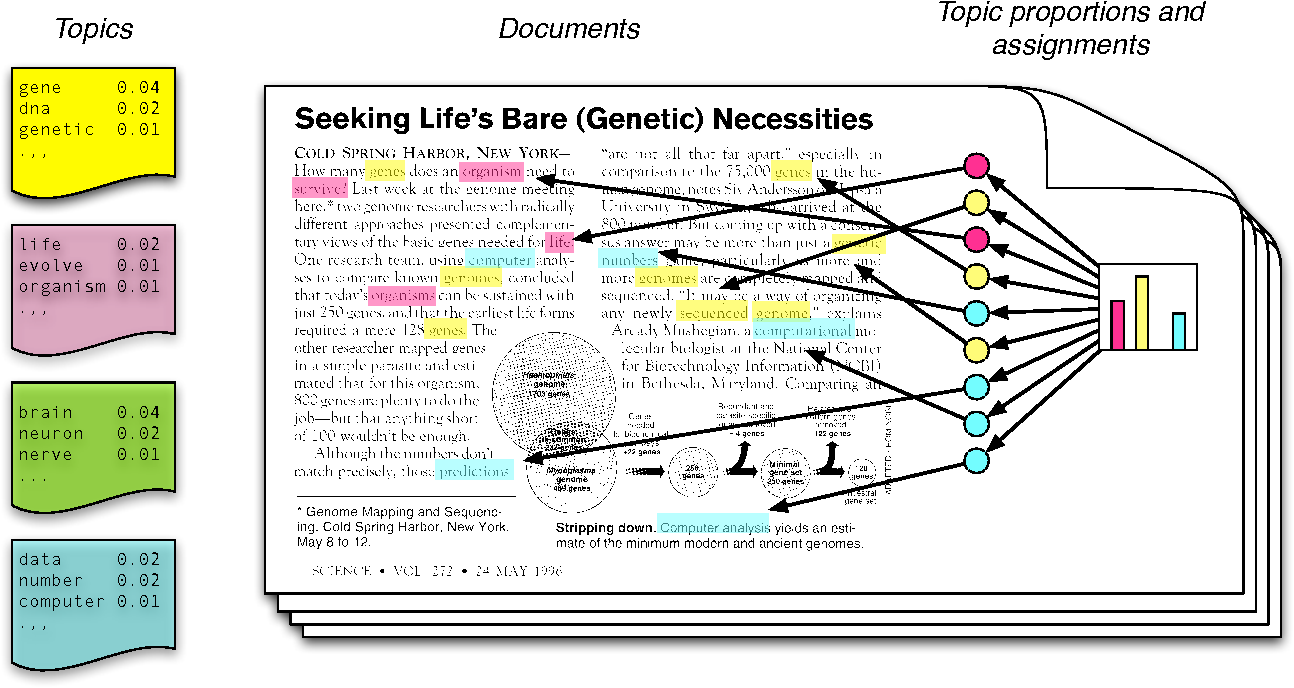

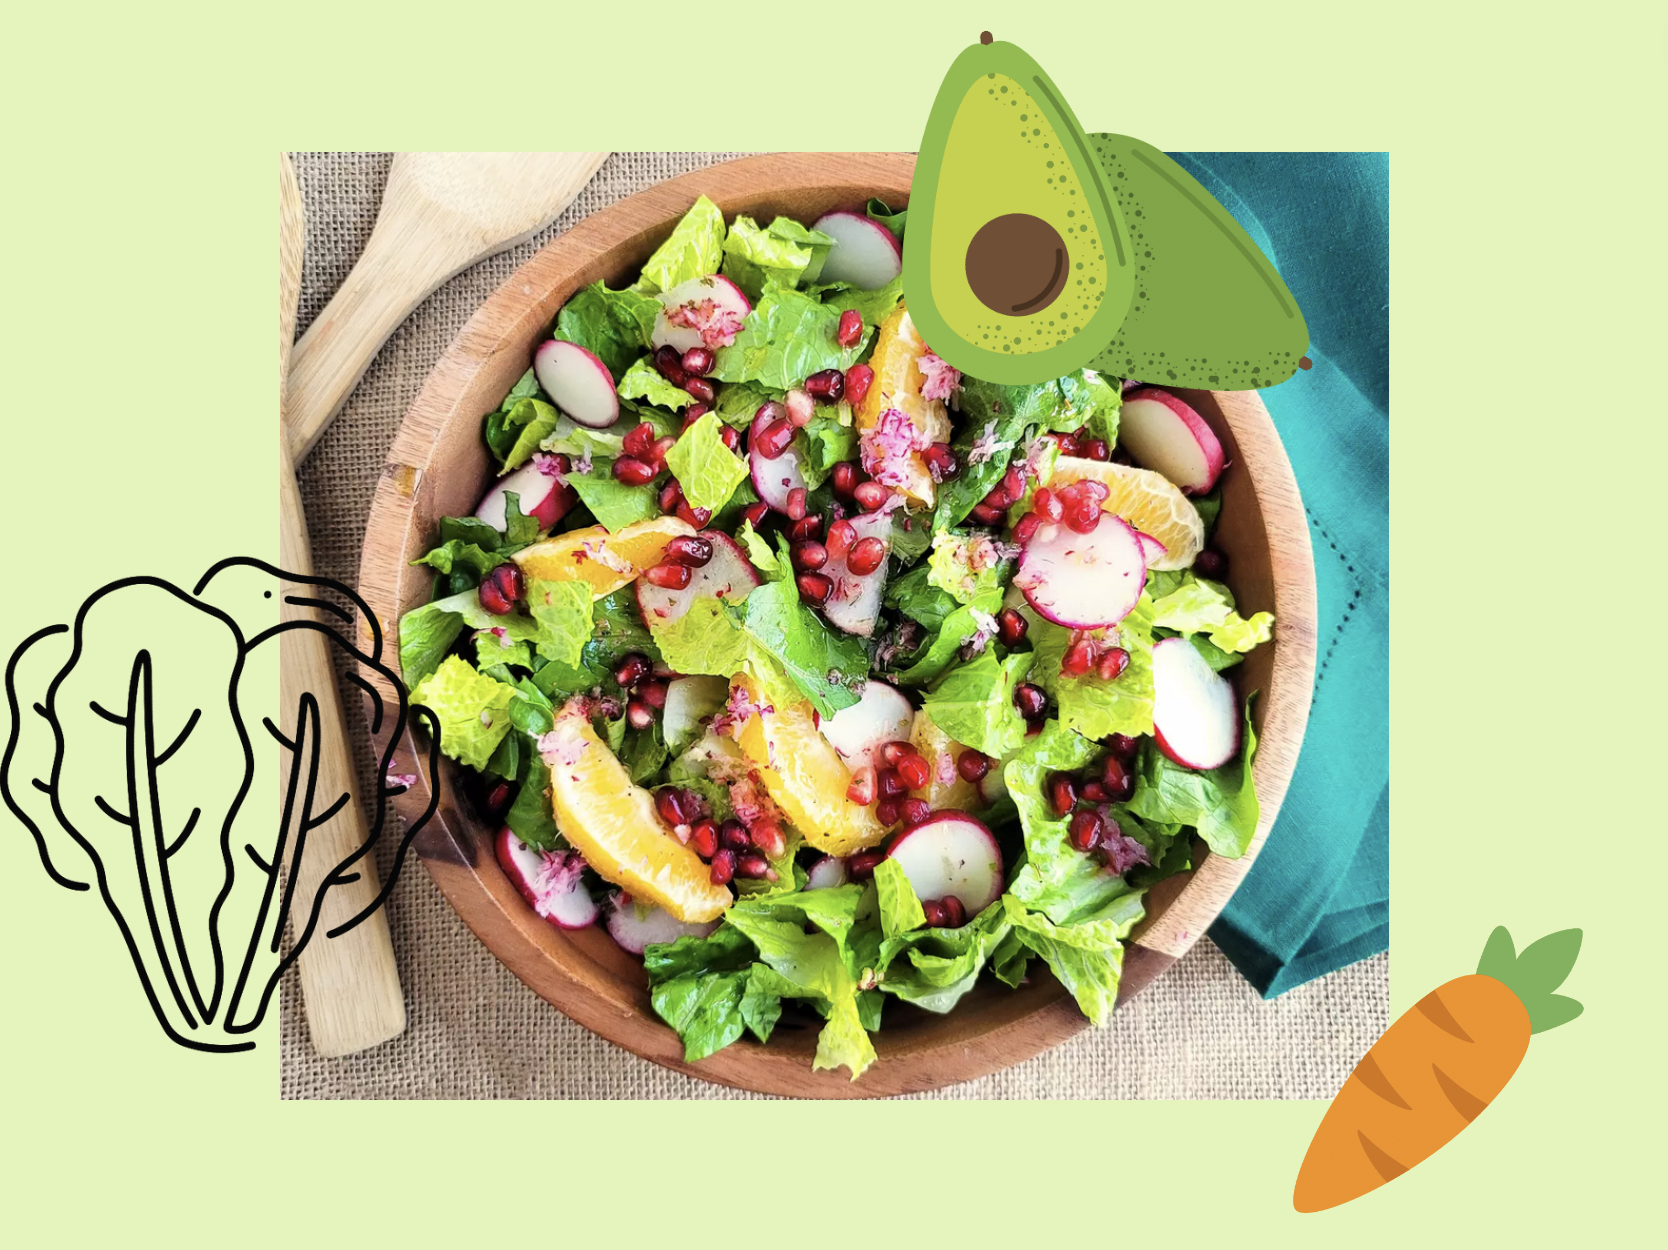

### Research example

"Medicine in the Monthly Review: Revealing public medical discourse with topic modelling"

Whitney Arnold and Corey Arnold

Digital Scholarship in the Humanities 

doi:10.1093/llc/fqab034 

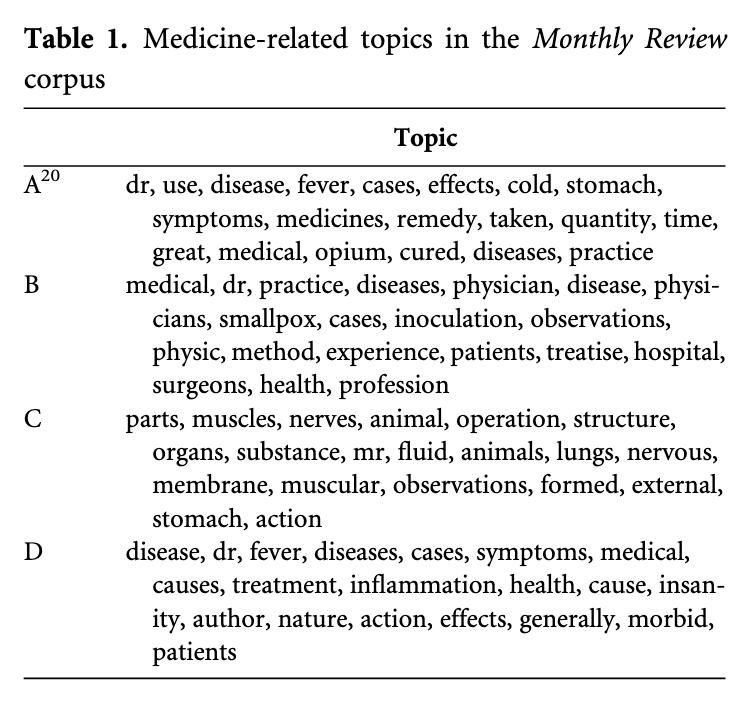


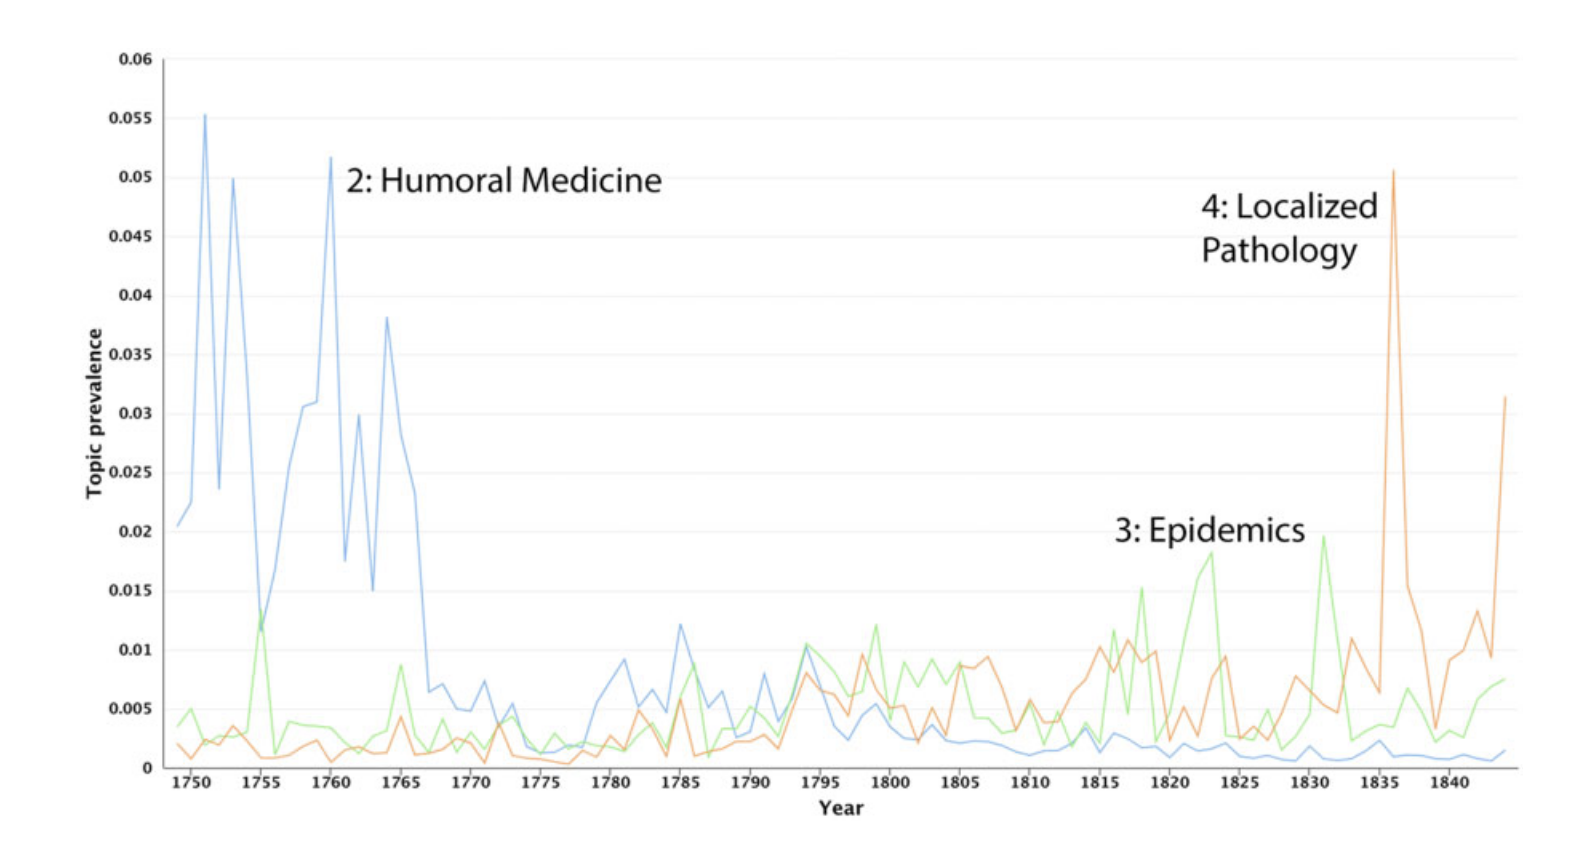

## This notebook

### Gensim

* "Topic modeling for humans"
* LDA topic modeling library for Python
* Intended for large datasets

Have you heard of other topic modeling tools or libraries?


### Set up

Libraries we need for this example:
* NLTK: data preparation
* Gensim: topic modeling
* Altair: visualization
* ipywidgets: visualization
* Matplotlib: visualization

Already installed on JupyterHub!

Working locally, you'd want to make sure you installed them before trying to use them in your notebook.

## Understand and import the data 

### The Liberator dataset

* 187 files of the Liberator, where each file is an issue. 
* Files have not been cleaned.
* Issues from 1901-1906 and 1910-1913. 

Dive deeper into the historical context of the Liberator in [these slides](https://docs.google.com/presentation/d/1gwAISOnn3Evq_LkX_0vhsYy0iTv7s5GHLUEGVKzN-tc/edit?usp=sharing). 


### Loading our data

Module needed:
* Glob: handy module to navigate a directory structure

The import statements will make them available for us to use in our notebook.

In [ ]:
  import glob

In [ ]:
directory_path = 'libSeparate'
text_files = glob.glob(f"{directory_path}/*")

Let's check to see that the files were brought in. We can use the list index to call the first text file in text_files.

In [ ]:
# change the number in the brackets to see a different file
text_files[0]

### Create list of our Liberator text

1. Create an empty list, listOfLib
2. Use a for loop and iterate through the files in text_files
3. Open and read each, and then apending them to listOfLib

In [ ]:
listOfLib = []
for i in text_files:
    try:
        with open(i) as f:
            listOfLib.append(f.read())
    except:
        pass

Let's check to make sure we got all the files using len(). The length is the number of items in the list. 

In [ ]:
len(text_files)

In [ ]:
len(listOfLib)

### Call items in listOfLib
* First brackets refer to a specific item in our list, in this case the 10th item.
    * Python starts counting at 0.
* Second brackets are optional and restrict what is returned to a slice of the data (characters 0 to 300). 
    * If we didn't slice, then we'd return the text of one entire issue of the Liberator. 

In [ ]:
listOfLib[9][0:300]

## Prepare the data

### Steps to take:

Using NLTK:
* Remove stopwords
* Tokenization
* Lemmatization

First, need to import relevant NLTK modules, plus a module called punctuation that will allow us to remove punctuation from the text. 

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

### Remove stopwords

Let's check out the NLTK stopword list to see what will get removed.

In [ ]:
standardStop = stopwords.words('english')
print (standardStop)

Create custom stopword list called extraStop that we will combine with the standard list in a new list. 

In [ ]:
extraStop = ['``',"''","'re","'s","'re",'``',"''","'ll","--","\'\'","...", "n\'t",'one','would','use','subject','from',
             "\'m","\'ve", "los", "angeles", "liberator", "phone", "street", "mrs."]

Create combined myStopWords list containing the punctuation marks, standardStop, and extraStop lists. Print the list to see it. 

In [ ]:
myStopWords = list(punctuation) + standardStop + extraStop

print(myStopWords)

### Tokenize


We're going to iterate through the words in the issues of the Liberator, lowercase them, tokenize them, and add them to a list called allLibWords, which will be a list of lists of words in each issue. 

In [ ]:
listOfLibWords = []
allLibWords = []
for i in listOfLib:
    processedText = [w for w in word_tokenize(i.lower()) if w not in myStopWords and len(w) > 3]
    listOfLibWords.append(processedText)
    for token in processedText:
        allLibWords.append(token)

### Lemmatize

We will iterate through the tokens in listOfLibWords, lemmatize them, and add them to listofLemWords.  

In [ ]:
listOfLemWords = []
wordnet_lemmatizer = WordNetLemmatizer()
for i in listOfLibWords:
    listOfLemWords.append([wordnet_lemmatizer.lemmatize(w) for w in i])

### The processed text
Let's take a look at a slice of tokens from list item 6.

In [ ]:
listOfLemWords[6][0:25]

What other steps might we have wanted to take to prepare our data?

## Structure the data

### List --> Dictionary --> Bag

Gensim expects the data in a certain format. 

First, we need to build a Gensim corpus (dictionary) from our list. Then we need to translate the dictionary into a bag-of-words. 


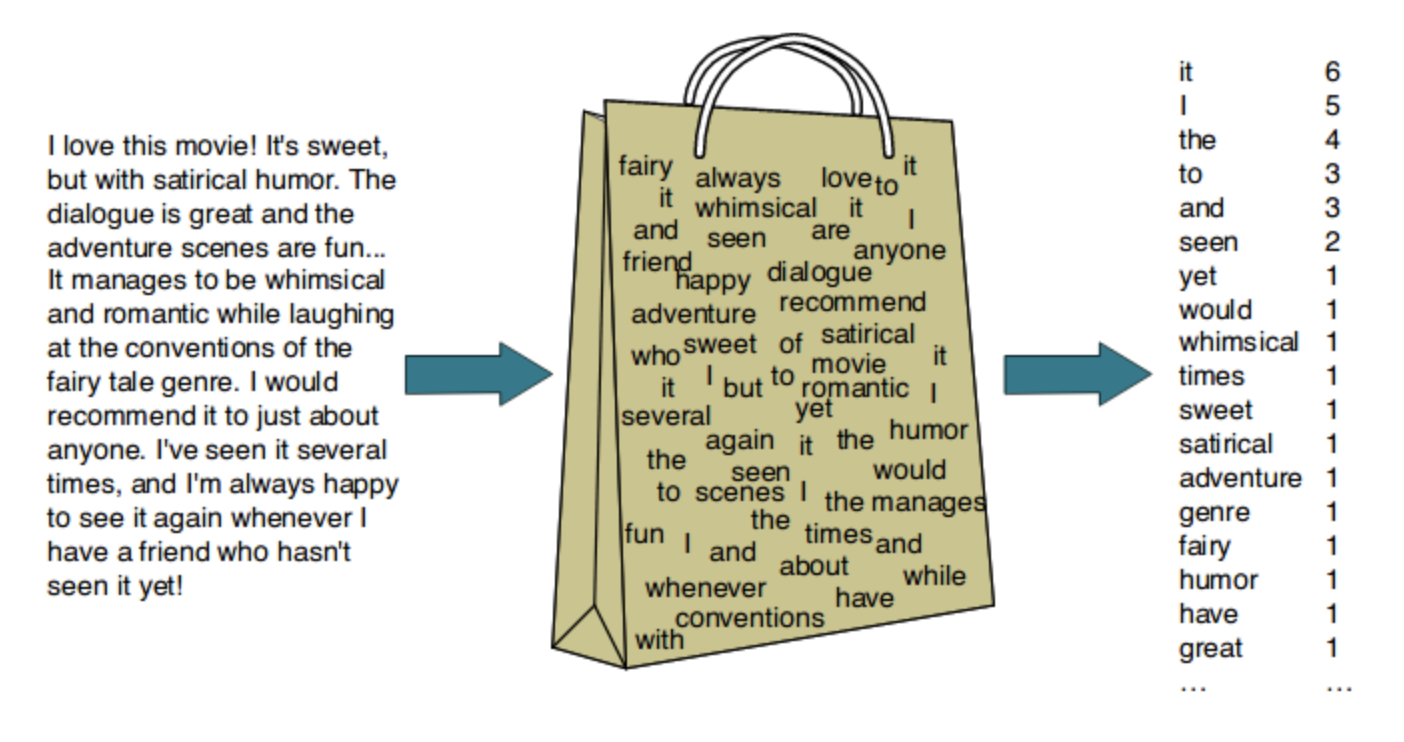


But before any of that, we need to import Gensim and the corpora and models modules.

In [ ]:
import gensim
from gensim import corpora

### Building our corpus

First, define a variable called dictionary. 

Gensim's corpora module will map the words in each document to integer IDs (i.e., assigning each unique word in the corpus a corresponding number).

In [ ]:
dictionary = corpora.Dictionary(listOfLemWords) 

We can check the ID of any token an our corpus. 

In [ ]:
#try looking up another word to find its ID
print(dictionary.token2id['help'])

Then define a new variable called corpus using Gensim's doc2bow.

The BOW will be a list of tuples -- consisting of word ID and frequency pairs -- that represent each document in our corpus. 

In [ ]:
corpus = [dictionary.doc2bow(text) for text in listOfLemWords]

Let's take a look at our corpus.

In [ ]:
print(corpus[9][0:300])

## Run the model and view topics

Gensim has a module called models for LDA topic modeling. We'll import the models module and then create our topics. 

In [ ]:
from gensim import models

### Parameters 

There are parameters that we have the option to set when creating the topic model. We're using just couple here:

* num_topics: the number of topics our model will create. This is a parameter you can adjust based on your corpus size and the length of the documents. 
* passes: the number of times the algorithm will pass through the documents. A higher number is likely to yield higher quality topics, but will take more time to run. 

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=10, 
                                           id2word = dictionary, 
                                           passes=20)

The notation show_topics() will return the 10 most salient words in each of our topics. 

In [ ]:
lda_model.show_topics()
#try adding a topic number (e.g., 5) and topn= 20 to see twenty words in topic 5, for example show_topic(9, topn=20)

This slightly more complicated code will print a cleaner list of our topics

In [ ]:
for i in range(10):
    print('Topic '+str(i))
    for j in lda_model.show_topic(i, topn=20):
            print(j[0])
    print('\n')

## Breakout activity

Play with the parameters and stopwords. 
* Adjust the parameters (number of topics and passes, or add more parameters from those available: https://radimrehurek.com/gensim/models/word2vec.html)
* Modify the stopword list

Then rerun your code.

## Visualize topics

Visualizing our topics will help us make sense of them. The code blocks in this section are a bit more complicated than what we saw above. 


First, let's import the modules we need:

* Altair: visualization library for Python
* ipywidgets: will make our visualizations interactive
* Pandas: common Python library for data science that is useful when working with tabular data
* Matplotlib: a very popular Python visualization library
* Seaborn: another Python visualization library 

Where you see the statements written "import ______ as ____", that's a way to abbreviate a module's name, mostly for the convenience of not typing the full name later. The abbreviations used here are common, so you may seem them if you look at other's code in the future. 

In [ ]:
import altair as alt
import ipywidgets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Another option?
pyLDAvis is another frequently used Python library for visualizing the outputs of Gensim topic models. The code is a bit simpler than what we're using here, but we think these custom visualizations are nicer! If you wanted to use pyLDAvis, you'd need to run:

In [ ]:
#import pyLDAvis
#import pyLDAvis.gensim_models
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, id2word, mds="mmds", R=30)
#vis

### Store the topics in a list

To go from the topics we produced into our visualizations, we need to prep our output data. First, we'll create a list of topic words.

Our code will:
* Create a variable called topics and set it to show_topics
* Create an empty list called topic_words
* Iterate through topics and append the tokens to the topic_words list

At the end, we print topic_words

In [ ]:
topics=lda_model.show_topics(5, 10,formatted=False)
topic_words = []
for topic in topics:
    topic_words.append([wd[0] for wd in topic[1]])
print(topic_words)

### Work with Pandas dataframes to develop the visualizations

Pandas? Dataframes? The important thing to know is that we are creating a dataframe, which you can think about like superpowered, code-accessible spreadsheet. 

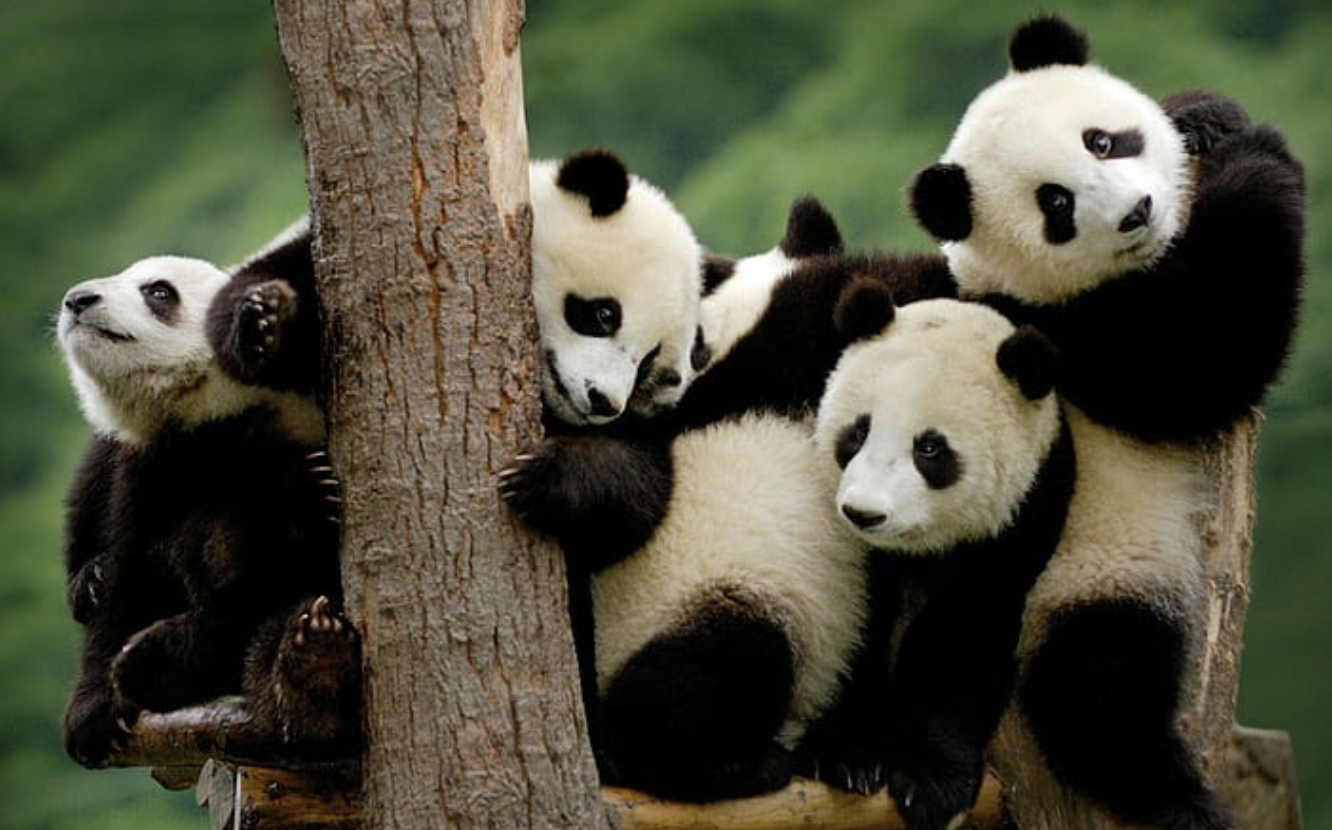

The code to create the dataframe includes Pandas syntax that will be unfamiliar! Just try to get a feel for what it's doing. Our dataframe will include the probability for each topic in each file in our corpus.

In [ ]:
ntopics = 10
dftopics = pd.DataFrame({'corpus':corpus})
filenames = []
topiclist = []
topicprob = []
topiccorpus = []
for i,row in dftopics.iterrows():
    probs = [0]*ntopics
    for t in lda_model.get_document_topics(row['corpus']):
        probs[t[0]] = t[1]
    for j in range(ntopics):
        topiccorpus.append('file'+str(i))
        topiclist.append(j)
        topicprob.append(probs[j])
topic_dataframe = pd.DataFrame({'corpus':topiccorpus,'topic':topiclist,'prob':topicprob})

If we call the dataframe, then we can get a feel for the tabular format.

In [ ]:
topic_dataframe

Then we can sort our dataframe to be ascending by topic. 

In [ ]:
topic_dataframe = topic_dataframe.sort_values(by=['topic','prob'],ascending=[True,False])

Here's another big code block! Again, let's just try to get a feel for what's happening. 

We're creating an interactive visualization that shows the dispersion of topics within our issues of the Liberator. 

In [ ]:
ntopics = 10
numwords = 10
selection = alt.selection_single(on='mouseover',fields=['topic'], bind='legend')
selopac = alt.selection_single(on='mouseover',fields=['topic'],bind='legend')
def topicbars(Topic):
    a = Topic
    topics_df_sorted = topic_dataframe[topic_dataframe['topic']==a].sort_values(by=['topic','prob'],ascending=False)
    topics_df_sorted = topics_df_sorted.append(topic_dataframe[topic_dataframe['topic']!=a])

    x=lda_model.show_topics(num_topics=ntopics, num_words=numwords,formatted=False)
    topic_words = []
    for topic in x:
        topic_words.append([wd[0] for wd in topic[1]])
    topics_df_sorted['topicwords'] = ''
    for i,row in topics_df_sorted.iterrows():
        topics_df_sorted.loc[i,'topicwords'] = ', '.join(topic_words[row['topic']])
    print("\n"+', '.join(topic_words[Topic])+"\n")
    
    chart = alt.Chart(topics_df_sorted).mark_bar().encode(
        x = 'sum(prob)',
        y = alt.X('corpus',sort=None),
        color = alt.Color('topic:N'),
        order = alt.Order('corpus'),
        opacity=alt.condition(selopac, alt.value(1), alt.value(0.5)),
        tooltip=['corpus', 'topic', 'prob', 'topicwords']
    ).add_selection(selopac)
        
    return chart

ipywidgets.interact(topicbars,Topic=range(ntopics))

### Modify our dataframes to create another visualization

Another view of the topics would be to show how prevalent each topic is within each file. 

To start, we can modify our dataframe so that topic is now rendered as a column.  

In [ ]:
topic_dataframe.pivot(index='corpus',columns='topic',values='prob')

Let's integrate that code into the code below to create a new dataframe where the words in each topic will now be brought in, instead of the topic number. Then we'll call the new dataframe. 

In [ ]:
ntopics = 10
numwords = 10

df_topic_words = topic_dataframe.pivot(index='corpus',columns='topic',values='prob')

x=lda_model.show_topics(num_topics=ntopics, num_words=numwords,formatted=False)
topic_words = []
for topic in x:
    topic_words.append(','.join([wd[0] for wd in topic[1]]))
df_topic_words.columns = topic_words

In [ ]:
df_topic_words

Finally, we can create our visualization of the df_topic_words. 

What is legible to you in the code that does this? What sense can we make?

In [ ]:
f, ax = plt.subplots(figsize=(20, 80))
ax = sns.heatmap(df_topic_words,
                 cmap="YlGnBu",
                 annot=True)
plt.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
plt.xticks(rotation=30, ha='left')
plt.yticks(rotation=0)
plt.show()

## Breakout activity

Comparing the visualizations they created with topic modeling to visualizations from day 1. Think about the methods we've discussed. When might you use one or another?

## Wrap-up